# Analyze Census Data with AI

- Use psycopg2 to load the data from the database into Python. 
- Use SQL filter the data to minimize the data transfer. 
- Use pandas and matplotlib to rocess and visualize the loaded data.
- Use OpenAI to assist coding.

### Secret Manager Function

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

### Connect to Database

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Modify and Query Tables with Cursor

###  Insert data
Insert a fake state with fips = 100

In [3]:
fips = '100'
name = 'fake_state'

sql_insert = f""" insert into name(fips,name)
                    values('{fips}','{name}')"""
print(sql_insert)

 insert into name(fips,name)
                    values('100','fake_state')


In [4]:
cur.execute(sql_insert)

In [5]:
conn.commit()

### Query data
Find the fake state

In [6]:
sql_query = f"""select * from name where fips = '{fips}'"""


In [7]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

('100', 'fake_state')


## Rollback
When errors occur, the cursor will be locked.

The following code will generate an error

In [8]:
cur.execute(sql_insert)

UniqueViolation: duplicate key value violates unique constraint "name_pkey"
DETAIL:  Key (fips)=(100) already exists.


And the cursor is now locked.

In [9]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

InFailedSqlTransaction: current transaction is aborted, commands ignored until end of transaction block


Unlock the cursor by using rollback

In [10]:
conn.rollback()

Cursor is now working

In [11]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

('100', 'fake_state')


Delete the fake state

In [12]:
sql_delete = f"""
            delete from name
            where fips = '{fips}'
            """
print(sql_delete)


            delete from name
            where fips = '100'
            


In [13]:
cur.execute(sql_delete)

In [14]:
conn.commit()

The fake state is now deleted. 

In [16]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

## Simple Data Analytics

### Display the VA Income Data Over Time

Define the SQL command. We filter the data based on the ```fips``` as it is a primary key.

In [23]:
sql = """
     select * from name_income
     where fips = '51'
     """

Use pandas to load the data and display the top 5 rows

In [24]:
import pandas as pd

va_df = pd.read_sql(sql, con=conn)
va_df.head() #show the top 5 rows

,fips,name,income,year
0,51,Virginia,54240,2005
1,51,Virginia,56277,2006
2,51,Virginia,59562,2007
3,51,Virginia,61233,2008
4,51,Virginia,59330,2009


Use a line chart to show the VA income over years.

<Axes: xlabel='year'>

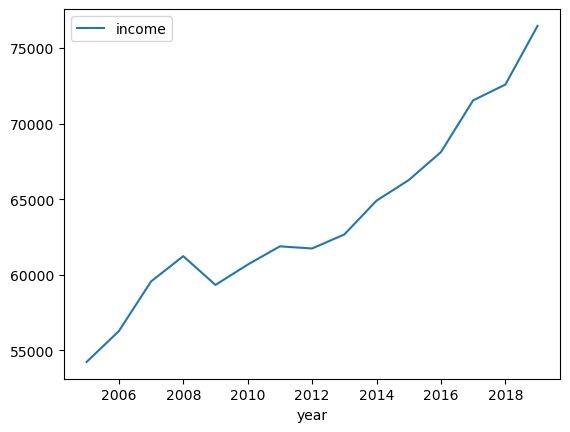

In [25]:
va_df.plot(x='year', y='income')

## Use AI to Assistant Data Analytics

### Install Python Packages

- jupyter-ai-magics: the JupyterLab AI to call Generative AI models

In [26]:
! pip install jupyter-ai-magics[all] -q

In [27]:
import warnings
warnings.simplefilter('ignore')

### Store OpenAI Key

In [28]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

### Load the Jupyter AI Magic Commands

In [29]:
%load_ext jupyter_ai_magics

The jupyter_ai_magics extension is already loaded. To reload it, use:
  %reload_ext jupyter_ai_magics


Optional: Check the available AI models

`%ai list`

### Explain Existing Codes

In [30]:
%%ai gpt4
What is included in the {va_df}

The given data includes:

- FIPS (Federal Information Processing Standards) code: "51" which represents Virginia.
- The state name: "Virginia".
- The average annual income in Virginia for each year from 2005 to 2019.
- The year for each income entry.

Optional: explain a code in a specific cell with cell number

`%%ai gpt4`

`explain the code in {In[#]} `

### Create New Codes with AI

In [33]:
%%ai gpt4 -f code
Calculate the growth rate with the data provided in {va_df}, use the va_df directly, and visualize the result on a line chart

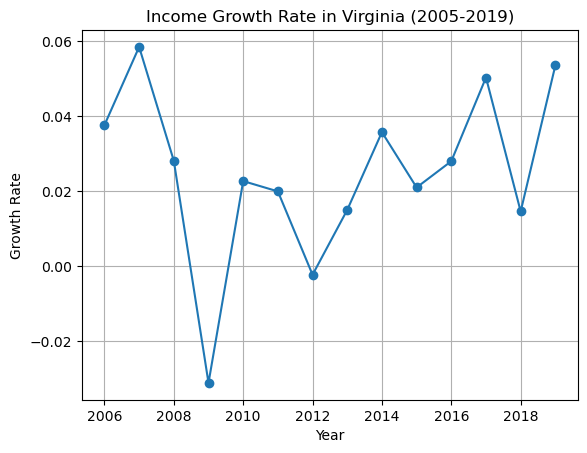

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the data is stored in a DataFrame named va_df
va_df = pd.DataFrame({
    'fips': [51]*15,
    'name': ['Virginia']*15,
    'income': [54240, 56277, 59562, 61233, 59330, 60674, 61882, 61741, 62666, 64902, 66262, 68114, 71535, 72577, 76456],
    'year': list(range(2005, 2020))
})

# Calculate the growth rate
va_df['growth_rate'] = va_df['income'].pct_change()

# Plotting the growth rate
plt.plot(va_df['year'], va_df['growth_rate'], '-o')
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.title('Income Growth Rate in Virginia (2005-2019)')
plt.grid(True)
plt.show()

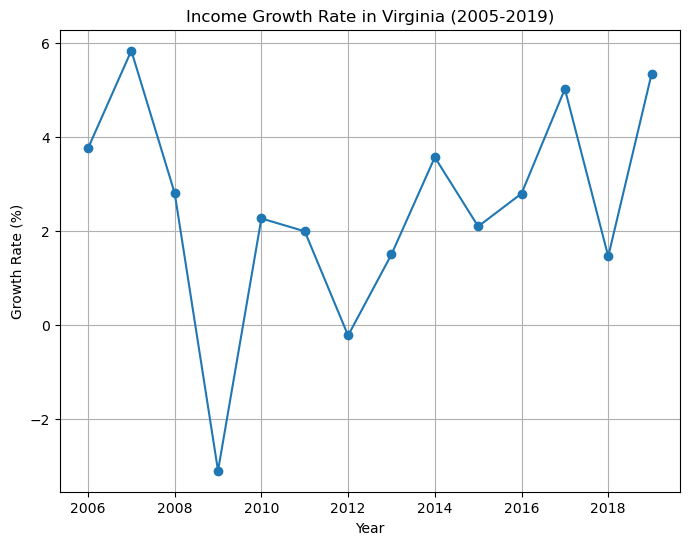

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the dataframe is named as va_df

va_df['growth_rate'] = va_df['income'].pct_change() * 100

plt.figure(figsize=(8, 6))
plt.plot(va_df['year'], va_df['growth_rate'], marker='o')
plt.title('Income Growth Rate in Virginia (2005-2019)')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

### A Complete Analysis with AI

Load the data from database into Python

In [37]:
%%ai gpt4 -f code
We have a view named name_income in an SQL database
You don't need to redefine the connection string
use the {conn} defined in {In[2]} to load all the recored into pandas dataframe 

In [ ]:
import pandas as pd
import psycopg2

# defined the connection string
conn = psycopg2.connect(host=get_secret('postgresql')['host'], user=get_secret('postgresql')['username'], password = get_secret('postgresql')['password'], dbname=get_secret('postgresql')['engine'])

# create a cursor
cur = conn.cursor()

# SQL query to load all records from view 'name_income'
query = "SELECT * FROM name_income;"

# execute the query and load data into a pandas dataframe
df = pd.read_sql_query(query, conn)

# close the cursor and connection
cur.close()
conn.close()

In [38]:
import pandas as pd

# Execute the SQL query
cur.execute("SELECT * FROM name_income")

# Fetch all the records
rows = cur.fetchall()

# Get the column names for the dataframe
column_names = [desc[0] for desc in cur.description]

# Create a pandas dataframe
df = pd.DataFrame(rows, columns=column_names)

df.head()

,fips,name,income,year
0,01,Alabama,36879,2005
1,02,Alaska,56234,2005
2,04,Arizona,44282,2005
3,05,Arkansas,34999,2005
4,06,California,53629,2005


In [39]:
%%ai gpt4 
What is the information in {df}

The provided data table includes four columns:

1. `fips` - Federal Information Processing Standards (FIPS) code: these are codes that indicate specific geographic areas in the United States. Each state has a unique two-digit code.

2. `name` - This is the name of the state or territory corresponding to the given FIPS code.

3. `income` - This indicates the income (likely average or median, but it's not specified in the provided information) for the given state or territory in a specific year.

4. `year` - This is the year that the income data relates to. Based on the provided data, the range is from 2005 to 2019.

The total rows of data are 780, which likely includes yearly income data for each state and some territories (such as Puerto Rico) from 2005 to 2019.

In [40]:
%%ai gpt4 -f code
Calculate the average year-over-year income growth rate for each state in {df} 
and create a chart to show the result

In [ ]:
import matplotlib.pyplot as plt

# Sorting the dataframe
df = df.sort_values(['name', 'year'])

# Calculating year-over-year growth for each state
df['income_growth'] = df.groupby('name')['income'].pct_change() * 100

# Calculating average growth rate for each state
average_growth_rate = df.groupby('name')['income_growth'].mean()

# Creating a bar chart
plt.figure(figsize=(20,10))
average_growth_rate.sort_values().plot(kind='bar')
plt.title('Average Year-Over-Year Income Growth Rate per State')
plt.xlabel('State')
plt.ylabel('Average Income Growth Rate (%)')
plt.xticks(rotation='vertical')
plt.show()

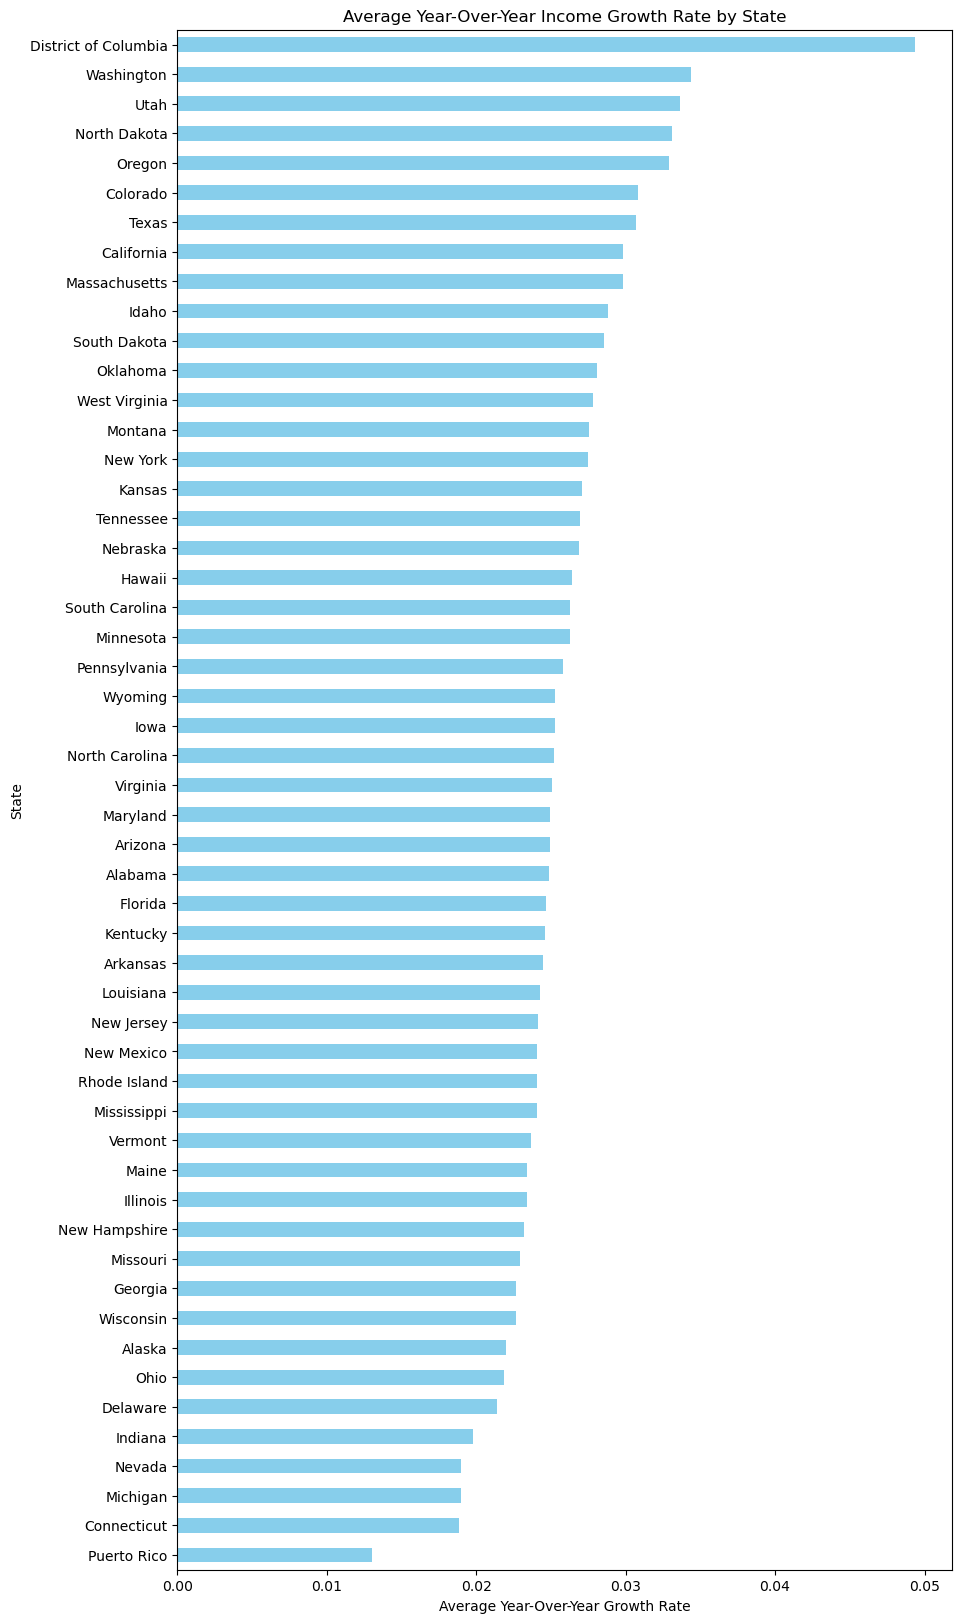

"\nThis Python code first converts the 'income' and 'year' columns to float and int data types, respectively. Then it sorts the DataFrame by 'name' and 'year', calculates the year-over-year income growth rate for each state and stores the result in the 'income_growth' column. The code then calculates the average income growth rate for each state and stores the result in the same DataFrame. Finally, the code creates a horizontal bar chart with the average income growth rate on the x-axis and the state on the y-axis. The chart is sorted in ascending order of growth rate.\n"

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the data is in a DataFrame named df
df['income'] = df['income'].astype(float)
df['year'] = df['year'].astype(int)

# Group by state and calculate the average annual growth rate
df = df.sort_values(['name', 'year'])
df['income_growth'] = df.groupby('name')['income'].pct_change() + 1
df = df.groupby('name')['income_growth'].agg('mean') - 1

# Create a bar chart
df.sort_values().plot(kind='barh', figsize=(10, 20), color='skyblue')

plt.title('Average Year-Over-Year Income Growth Rate by State')
plt.xlabel('Average Year-Over-Year Growth Rate')
plt.ylabel('State')

plt.show()
'''
This Python code first converts the 'income' and 'year' columns to float and int data types, respectively. Then it sorts the DataFrame by 'name' and 'year', calculates the year-over-year income growth rate for each state and stores the result in the 'income_growth' column. The code then calculates the average income growth rate for each state and stores the result in the same DataFrame. Finally, the code creates a horizontal bar chart with the average income growth rate on the x-axis and the state on the y-axis. The chart is sorted in ascending order of growth rate.
'''

## Close Database Connection

In [42]:
#run the folloiwng code if the connection is not closed

cur.close()
conn.close()